Importy:

In [2]:
import torch
from torch import nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import optuna
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
from PIL import Image
import torchvision.transforms.functional as F
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

Model dyskryminatora:

In [3]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=(4, 4), stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=(4, 4), stride=2, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=(4, 4), stride=2, padding=1)

        self.batch_norm1 = torch.nn.BatchNorm2d(32)
        self.batch_norm2 = torch.nn.BatchNorm2d(64)
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.leaky_relu = torch.nn.LeakyReLU(0.2)

        self.flat = torch.nn.Flatten()
        self.dropout = torch.nn.Dropout(p=0.2)
        self.fc = torch.nn.Linear(64 * 4 * 4, 1)

        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.batch_norm1(self.conv1(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv3(x)))

        x = self.flat(x)
        
        x = self.sigmoid(self.fc(self.dropout(x)))

        return x

Model generatora:

In [4]:
class Generator(torch.nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.fc = torch.nn.Linear(64, 64 * 4 * 4)

        # Torch w ConvTranspose2d nie obsuguje paddingu same
        self.conv1 = torch.nn.ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=2, padding=1)
        self.conv2 = torch.nn.ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=2, padding=1)
        self.conv3 = torch.nn.ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=2, padding=1)

        self.leaky_relu = torch.nn.LeakyReLU(0.2)
        self.convRGB = torch.nn.Conv2d(256, 3, kernel_size=(5, 5), stride=1, padding=2)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = self.fc(x)

        x = x.view(-1, 64, 4, 4)

        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))

        x = self.tanh(self.convRGB(x))

        return x

Test generatora:

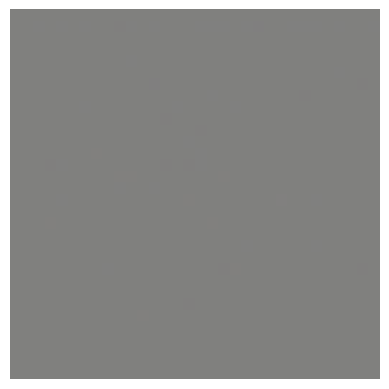

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator()

random_noise = torch.randn(1, 64)

with torch.no_grad():
    generated_image = generator(random_noise)

generated_image = generated_image.squeeze().permute(1, 2, 0)

generated_image = (generated_image + 1) / 2

plt.imshow(generated_image.clamp(0, 1))
plt.axis('off')
plt.show()

Wczytanie zdjęć ciastek marchewkowych:

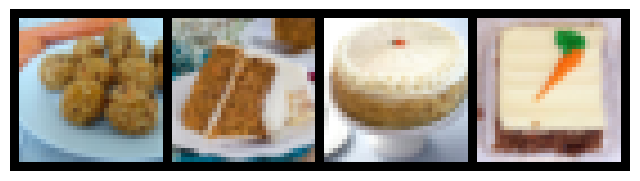

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(image_dir) if file.endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_dir = "crawled_cakes"
dataset = CustomImageDataset(image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

data_iter = iter(dataloader)
images = next(data_iter)

images_data = []
for batch in dataloader:
    images_data.append(batch)
images_data = torch.cat(images_data, dim=0).to(device)

images_to_show = (images + 1) / 2

grid_img = torchvision.utils.make_grid(images_to_show[:4], nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

Test:

In [7]:
class SmallModel(torch.nn.Module):

    def __init__(self):
        super(SmallModel, self).__init__()

        self.fc = torch.nn.Linear(2, 3)
        self.fc2 = torch.nn.Linear(3, 2)

    def forward(self, x):
        x = self.fc(x)
        x = self.fc2(x)

        return x

In [8]:
random_batch = torch.randn(10, 2)

small_model = SmallModel()
optimizer = torch.optim.SGD(small_model.parameters())
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0

    for numbers in random_batch:
        optimizer.zero_grad()
        output = small_model(numbers)

        output_mean = torch.mean(output)

        loss = (output_mean - 42) ** 2

        loss.backward() 
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoka [{epoch + 1}/{num_epochs}], Strata: {running_loss / len(random_batch):.4f}")


Epoka [1/10], Strata: 1742.0376
Epoka [2/10], Strata: 1612.3632
Epoka [3/10], Strata: 1350.9763
Epoka [4/10], Strata: 876.4308
Epoka [5/10], Strata: 347.1526
Epoka [6/10], Strata: 73.6727
Epoka [7/10], Strata: 11.7136
Epoka [8/10], Strata: 3.4037
Epoka [9/10], Strata: 1.9233
Epoka [10/10], Strata: 1.2684


Przygotowanie danych dla dyskryminatora:

In [9]:
images_1 = images_data[:16]
images_1 = torch.stack([img for img in images_1], dim=0)

images_0 = []
random_noises = [torch.randn(64) for _ in range(16)]

for random_noise in random_noises:
    with torch.no_grad():
        generated_image = generator(random_noise.unsqueeze(0))
        generated_image = torch.nn.functional.interpolate(generated_image, size=(32, 32), mode='bilinear', align_corners=False)
        images_0.append(generated_image)

images_0 = torch.cat(images_0, dim=0).to(device)

all_images = torch.cat([images_1, images_0], dim=0)
all_labels = torch.tensor([1] * len(images_1) + [0] * len(images_0), dtype=torch.float32)

for i in range(len(all_labels)):
    random_shuffle = (0.05) * torch.rand(1)
    if all_labels[i] == 0:
        all_labels[i] += random_shuffle.item()
    else:
        all_labels[i] -= random_shuffle.item()

Nauka dyskryminatora:

In [10]:
discriminator = Discriminator().to(device)

optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00001, weight_decay=0.01)
loss = nn.BCELoss()
losses = []

for i in range(len(all_images)):
    optimizer.zero_grad()
    image = all_images[i].unsqueeze(0)
    output = discriminator(image)
    output_loss = loss(output[0], all_labels[i].unsqueeze(0).to(device))

    output_loss.backward()
    optimizer.step()
    losses.append(output_loss.item())

print(losses)

[0.7411988973617554, 0.6891158223152161, 0.729195773601532, 0.4892890751361847, 0.6574856638908386, 0.7245289087295532, 0.6818897724151611, 0.9022480845451355, 0.4886156916618347, 0.8404752016067505, 0.8002569079399109, 0.5975592732429504, 0.5096423029899597, 0.8400021195411682, 0.681110143661499, 0.6915060877799988, 0.7645071744918823, 0.7349446415901184, 1.2456074953079224, 0.556195855140686, 1.0404410362243652, 0.8770785331726074, 0.7115694880485535, 1.1917991638183594, 0.7317990064620972, 0.4391615688800812, 0.5396249294281006, 0.61467045545578, 0.34268492460250854, 0.5986963510513306, 0.7705413103103638, 0.5482587814331055]


Teraz poprawimy trochę generator:

In [11]:
images_0 = []
random_noises = [torch.randn(64) for _ in range(16)]
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.00001)

for random_noise in random_noises:
    with torch.no_grad():
        generated_image = generator(random_noise.unsqueeze(0))

        if generated_image.dim() == 3:  
            generated_image = generated_image.unsqueeze(0)

        generated_image = torch.nn.functional.interpolate(generated_image, size=(32, 32), mode='bilinear', align_corners=False)

        if generated_image.shape[1] == 1:
            generated_image = generated_image.repeat(1, 3, 1, 1)
        
        images_0.append(generated_image)

images_0 = torch.cat(images_0, dim=0)
labels_0 = torch.ones(16, dtype=torch.float32)

loss = nn.BCELoss()
losses_generator = []

for i in range(len(images_0)):
    optimizer_generator.zero_grad()
    image = images_0[i].unsqueeze(0).to(device)
    output = discriminator(image)
    output_loss = loss(output[0], labels_0[i].unsqueeze(0).to(device))

    output_loss.backward()
    optimizer_generator.step()
    losses_generator.append(output_loss.item())

print(losses_generator)

[0.8835705518722534, 0.9534198045730591, 0.7264997959136963, 0.882218062877655, 0.6953272819519043, 0.6078038215637207, 0.6392021179199219, 0.9366817474365234, 0.773559033870697, 0.8830666542053223, 0.6097269058227539, 1.126805067062378, 1.1416950225830078, 1.0296132564544678, 0.998581051826477, 0.5936334133148193]


Kilka funkcji do zapisu stanu modelu:

In [12]:
random_noises_const = torch.randn(16, 64).to(device)

def save_models(epoch, generator, discriminator, optimizer_gen, optimizer_disc):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_gen_state_dict': optimizer_gen.state_dict(),
        'optimizer_disc_state_dict': optimizer_disc.state_dict(),
    }, f'model_checkpoints/checkpoint_epoch_{epoch}.pth')

def save_generated_images(generator, epoch, save_dir):
    generator = generator.to(device)
    generated_image = generator(random_noises_const.to(device))

    images = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min() + 1e-5)
    grid_img = torchvision.utils.make_grid(images, nrow=4, normalize=True, scale_each=True)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0).cpu().detach().numpy())
    plt.title(f'Epoch {epoch}')
    plt.savefig(os.path.join(save_dir, f'generated_epoch_{epoch}.png'))
    plt.close()

Trenujemy mocniej:

In [13]:
discriminator = Discriminator().to(device)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.00001, weight_decay=0.01)
loss_fn = nn.BCELoss()

def train_discriminator(batches):
    total_loss = 0

    for images in batches:
        images = images.to(device)
        discriminator.zero_grad()
        labels = 1 - ((0.05) * torch.rand(images.size()[0]).to(device))
        outputs = discriminator(images).to(device)
        
        discriminator_loss = loss_fn(outputs, labels.unsqueeze(1))
        discriminator_loss.backward()

        random_noises = torch.randn(images.size()[0], 64).to(device)
        random_labels = 0 + ((0.05) * torch.rand(images.size()[0]).to(device))
        generated_image = generator(random_noises).to(device)
        outputs = discriminator(generated_image).to(device)

        generator_loss = loss_fn(outputs, random_labels.unsqueeze(1))
        generator_loss.backward()
        optimizer_discriminator.step()

        total_loss += generator_loss.item()

    return total_loss / len(dataloader)

In [14]:
generator = Generator().to(device)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.00001)

def train_generator(batches):
    total_loss = 0

    for images in batches:
        generator.zero_grad()
        random_noises = torch.randn(images.size()[0], 64).to(device)
        generated_image = generator(random_noises).to(device)
        outputs = discriminator(generated_image).to(device)
        
        generator_loss = loss_fn(outputs, torch.ones(images.size()[0]).unsqueeze(1).to(device))
        generator_loss.backward()
        optimizer_generator.step()

        total_loss += generator_loss.item()

    return total_loss / len(dataloader)

In [ ]:
history_discriminator_loss = []
history_generator_loss = []

my_batch_size = 16
batches = [images_data[i:i + my_batch_size] for i in range(0, len(images_data), my_batch_size)]

N = 50
num_epochs = 3000
save_dir = 'model_checkpoints'
os.makedirs(save_dir, exist_ok=True)
pbar = tqdm(range(num_epochs))

for epoch in pbar:
    discriminator_loss = train_discriminator(batches)
    generator_loss = train_generator(batches)
    pbar.set_description(f"Epoch [{epoch}/{num_epochs}], Loss D: {discriminator_loss:.4f}, Loss G: {generator_loss:.4f}")

    if epoch % N == 0:
        save_models(epoch, generator, discriminator, optimizer_generator, optimizer_discriminator)
        save_generated_images(generator, epoch, save_dir)
        print(f"Epoch [{epoch}/{num_epochs}], Loss D: {discriminator_loss:.4f}, Loss G: {generator_loss:.4f}")

Epoch [0/3000], Loss D: 0.4549, Loss G: 0.4960:   0%|          | 1/3000 [00:01<1:12:31,  1.45s/it]

Epoch [0/3000], Loss D: 0.4549, Loss G: 0.4960


Epoch [50/3000], Loss D: 0.4349, Loss G: 1.0863:   2%|▏         | 51/3000 [00:52<51:02,  1.04s/it]

Epoch [50/3000], Loss D: 0.4349, Loss G: 1.0863


Epoch [100/3000], Loss D: 0.6797, Loss G: 0.7255:   3%|▎         | 101/3000 [01:43<50:13,  1.04s/it]

Epoch [100/3000], Loss D: 0.6797, Loss G: 0.7255


Epoch [150/3000], Loss D: 0.6441, Loss G: 0.7601:   5%|▌         | 151/3000 [02:35<49:26,  1.04s/it]

Epoch [150/3000], Loss D: 0.6441, Loss G: 0.7601


Epoch [200/3000], Loss D: 0.6221, Loss G: 0.7378:   7%|▋         | 201/3000 [03:25<48:09,  1.03s/it]

Epoch [200/3000], Loss D: 0.6221, Loss G: 0.7378


Epoch [250/3000], Loss D: 0.6465, Loss G: 0.7356:   8%|▊         | 251/3000 [04:16<47:40,  1.04s/it]

Epoch [250/3000], Loss D: 0.6465, Loss G: 0.7356


Epoch [300/3000], Loss D: 0.6551, Loss G: 0.7418:  10%|█         | 301/3000 [05:07<46:27,  1.03s/it]

Epoch [300/3000], Loss D: 0.6551, Loss G: 0.7418


Epoch [350/3000], Loss D: 0.6545, Loss G: 0.7571:  12%|█▏        | 351/3000 [05:58<45:36,  1.03s/it]

Epoch [350/3000], Loss D: 0.6545, Loss G: 0.7571


Epoch [400/3000], Loss D: 0.5877, Loss G: 0.8106:  13%|█▎        | 401/3000 [06:49<44:41,  1.03s/it]

Epoch [400/3000], Loss D: 0.5877, Loss G: 0.8106


Epoch [450/3000], Loss D: 0.6161, Loss G: 0.7584:  15%|█▌        | 451/3000 [07:40<43:56,  1.03s/it]

Epoch [450/3000], Loss D: 0.6161, Loss G: 0.7584


Epoch [500/3000], Loss D: 0.5910, Loss G: 0.7694:  17%|█▋        | 501/3000 [08:31<43:17,  1.04s/it]

Epoch [500/3000], Loss D: 0.5910, Loss G: 0.7694


Epoch [550/3000], Loss D: 0.5414, Loss G: 0.8099:  18%|█▊        | 551/3000 [09:22<42:08,  1.03s/it]

Epoch [550/3000], Loss D: 0.5414, Loss G: 0.8099


Epoch [600/3000], Loss D: 0.5126, Loss G: 0.8521:  20%|██        | 601/3000 [10:13<41:12,  1.03s/it]

Epoch [600/3000], Loss D: 0.5126, Loss G: 0.8521


Epoch [650/3000], Loss D: 0.5202, Loss G: 0.8796:  22%|██▏       | 651/3000 [11:04<40:43,  1.04s/it]

Epoch [650/3000], Loss D: 0.5202, Loss G: 0.8796


Epoch [700/3000], Loss D: 0.4643, Loss G: 0.8507:  23%|██▎       | 701/3000 [11:55<39:39,  1.04s/it]

Epoch [700/3000], Loss D: 0.4643, Loss G: 0.8507


Epoch [750/3000], Loss D: 0.4559, Loss G: 0.8915:  25%|██▌       | 751/3000 [12:46<38:57,  1.04s/it]

Epoch [750/3000], Loss D: 0.4559, Loss G: 0.8915


Epoch [800/3000], Loss D: 0.4320, Loss G: 0.9698:  27%|██▋       | 801/3000 [13:37<37:56,  1.04s/it]

Epoch [800/3000], Loss D: 0.4320, Loss G: 0.9698


Epoch [850/3000], Loss D: 0.3964, Loss G: 0.9555:  28%|██▊       | 851/3000 [14:28<37:04,  1.04s/it]

Epoch [850/3000], Loss D: 0.3964, Loss G: 0.9555


Epoch [900/3000], Loss D: 0.3654, Loss G: 1.0039:  30%|███       | 901/3000 [15:19<36:16,  1.04s/it]

Epoch [900/3000], Loss D: 0.3654, Loss G: 1.0039


Epoch [950/3000], Loss D: 0.3516, Loss G: 1.0526:  32%|███▏      | 951/3000 [16:10<35:19,  1.03s/it]

Epoch [950/3000], Loss D: 0.3516, Loss G: 1.0526


Epoch [1000/3000], Loss D: 0.3717, Loss G: 1.2362:  33%|███▎      | 1001/3000 [17:02<34:41,  1.04s/it]

Epoch [1000/3000], Loss D: 0.3717, Loss G: 1.2362


Epoch [1050/3000], Loss D: 0.3389, Loss G: 1.2314:  35%|███▌      | 1051/3000 [17:53<33:32,  1.03s/it]

Epoch [1050/3000], Loss D: 0.3389, Loss G: 1.2314


Epoch [1100/3000], Loss D: 0.3057, Loss G: 1.3249:  37%|███▋      | 1101/3000 [18:44<32:31,  1.03s/it]

Epoch [1100/3000], Loss D: 0.3057, Loss G: 1.3249


Epoch [1150/3000], Loss D: 0.2849, Loss G: 1.1977:  38%|███▊      | 1151/3000 [19:35<32:03,  1.04s/it]

Epoch [1150/3000], Loss D: 0.2849, Loss G: 1.1977


Epoch [1200/3000], Loss D: 0.2694, Loss G: 1.2819:  40%|████      | 1201/3000 [20:26<31:03,  1.04s/it]

Epoch [1200/3000], Loss D: 0.2694, Loss G: 1.2819


Epoch [1250/3000], Loss D: 0.2791, Loss G: 1.4260:  42%|████▏     | 1251/3000 [21:16<30:08,  1.03s/it]

Epoch [1250/3000], Loss D: 0.2791, Loss G: 1.4260


Epoch [1300/3000], Loss D: 0.2896, Loss G: 1.7787:  43%|████▎     | 1301/3000 [22:08<29:22,  1.04s/it]

Epoch [1300/3000], Loss D: 0.2896, Loss G: 1.7787


Epoch [1350/3000], Loss D: 0.2623, Loss G: 1.5770:  45%|████▌     | 1351/3000 [22:58<28:20,  1.03s/it]

Epoch [1350/3000], Loss D: 0.2623, Loss G: 1.5770


Epoch [1400/3000], Loss D: 0.2652, Loss G: 1.7618:  47%|████▋     | 1401/3000 [23:49<27:47,  1.04s/it]

Epoch [1400/3000], Loss D: 0.2652, Loss G: 1.7618


Epoch [1450/3000], Loss D: 0.2497, Loss G: 1.8646:  48%|████▊     | 1451/3000 [24:41<27:01,  1.05s/it]

Epoch [1450/3000], Loss D: 0.2497, Loss G: 1.8646


Epoch [1500/3000], Loss D: 0.2340, Loss G: 1.9148:  50%|█████     | 1501/3000 [25:32<26:01,  1.04s/it]

Epoch [1500/3000], Loss D: 0.2340, Loss G: 1.9148


Epoch [1550/3000], Loss D: 0.2202, Loss G: 1.9791:  52%|█████▏    | 1551/3000 [26:23<25:02,  1.04s/it]

Epoch [1550/3000], Loss D: 0.2202, Loss G: 1.9791


Epoch [1600/3000], Loss D: 0.2176, Loss G: 2.0847:  53%|█████▎    | 1601/3000 [27:14<24:07,  1.03s/it]

Epoch [1600/3000], Loss D: 0.2176, Loss G: 2.0847


Epoch [1650/3000], Loss D: 0.2109, Loss G: 2.1181:  55%|█████▌    | 1651/3000 [28:05<23:14,  1.03s/it]

Epoch [1650/3000], Loss D: 0.2109, Loss G: 2.1181


Epoch [1700/3000], Loss D: 0.2124, Loss G: 2.3284:  57%|█████▋    | 1701/3000 [28:56<22:39,  1.05s/it]

Epoch [1700/3000], Loss D: 0.2124, Loss G: 2.3284


Epoch [1750/3000], Loss D: 0.2101, Loss G: 2.3016:  58%|█████▊    | 1751/3000 [29:47<21:30,  1.03s/it]

Epoch [1750/3000], Loss D: 0.2101, Loss G: 2.3016


Epoch [1800/3000], Loss D: 0.2045, Loss G: 2.3011:  60%|██████    | 1801/3000 [30:38<20:40,  1.03s/it]

Epoch [1800/3000], Loss D: 0.2045, Loss G: 2.3011


Epoch [1850/3000], Loss D: 0.1949, Loss G: 2.4691:  62%|██████▏   | 1851/3000 [31:30<19:42,  1.03s/it]

Epoch [1850/3000], Loss D: 0.1949, Loss G: 2.4691


Epoch [1900/3000], Loss D: 0.1974, Loss G: 2.5220:  63%|██████▎   | 1901/3000 [32:21<19:02,  1.04s/it]

Epoch [1900/3000], Loss D: 0.1974, Loss G: 2.5220


Epoch [1950/3000], Loss D: 0.1944, Loss G: 2.4731:  65%|██████▌   | 1951/3000 [33:12<18:11,  1.04s/it]

Epoch [1950/3000], Loss D: 0.1944, Loss G: 2.4731


Epoch [2000/3000], Loss D: 0.1852, Loss G: 2.5558:  67%|██████▋   | 2001/3000 [34:03<17:23,  1.04s/it]

Epoch [2000/3000], Loss D: 0.1852, Loss G: 2.5558


Epoch [2050/3000], Loss D: 0.1899, Loss G: 2.4857:  68%|██████▊   | 2051/3000 [34:54<16:27,  1.04s/it]

Epoch [2050/3000], Loss D: 0.1899, Loss G: 2.4857


Epoch [2100/3000], Loss D: 0.1881, Loss G: 2.7347:  70%|███████   | 2101/3000 [35:45<15:28,  1.03s/it]

Epoch [2100/3000], Loss D: 0.1881, Loss G: 2.7347


Epoch [2150/3000], Loss D: 0.1813, Loss G: 2.6401:  72%|███████▏  | 2151/3000 [36:37<14:49,  1.05s/it]

Epoch [2150/3000], Loss D: 0.1813, Loss G: 2.6401


Epoch [2200/3000], Loss D: 0.1823, Loss G: 2.7550:  73%|███████▎  | 2201/3000 [37:28<13:49,  1.04s/it]

Epoch [2200/3000], Loss D: 0.1823, Loss G: 2.7550


Epoch [2250/3000], Loss D: 0.1742, Loss G: 2.5307:  75%|███████▌  | 2251/3000 [38:19<12:57,  1.04s/it]

Epoch [2250/3000], Loss D: 0.1742, Loss G: 2.5307


Epoch [2300/3000], Loss D: 0.1800, Loss G: 2.7178:  77%|███████▋  | 2301/3000 [39:10<12:05,  1.04s/it]

Epoch [2300/3000], Loss D: 0.1800, Loss G: 2.7178


Epoch [2350/3000], Loss D: 0.1739, Loss G: 2.6241:  78%|███████▊  | 2351/3000 [40:01<11:15,  1.04s/it]

Epoch [2350/3000], Loss D: 0.1739, Loss G: 2.6241


Epoch [2400/3000], Loss D: 0.1713, Loss G: 2.6253:  80%|████████  | 2401/3000 [40:52<10:23,  1.04s/it]

Epoch [2400/3000], Loss D: 0.1713, Loss G: 2.6253


Epoch [2450/3000], Loss D: 0.1674, Loss G: 2.7742:  82%|████████▏ | 2451/3000 [41:43<09:27,  1.03s/it]

Epoch [2450/3000], Loss D: 0.1674, Loss G: 2.7742


Epoch [2500/3000], Loss D: 0.1696, Loss G: 2.6735:  83%|████████▎ | 2501/3000 [42:35<08:42,  1.05s/it]

Epoch [2500/3000], Loss D: 0.1696, Loss G: 2.6735


Epoch [2550/3000], Loss D: 0.1638, Loss G: 2.6724:  85%|████████▌ | 2551/3000 [43:26<07:46,  1.04s/it]

Epoch [2550/3000], Loss D: 0.1638, Loss G: 2.6724


Epoch [2600/3000], Loss D: 0.1638, Loss G: 2.8450:  87%|████████▋ | 2601/3000 [44:17<06:53,  1.04s/it]

Epoch [2600/3000], Loss D: 0.1638, Loss G: 2.8450


Epoch [2650/3000], Loss D: 0.1722, Loss G: 3.0333:  88%|████████▊ | 2651/3000 [45:08<06:04,  1.04s/it]

Epoch [2650/3000], Loss D: 0.1722, Loss G: 3.0333


Epoch [2700/3000], Loss D: 0.1699, Loss G: 2.9093:  90%|█████████ | 2701/3000 [45:59<05:09,  1.03s/it]

Epoch [2700/3000], Loss D: 0.1699, Loss G: 2.9093


Epoch [2750/3000], Loss D: 0.1662, Loss G: 2.9797:  92%|█████████▏| 2751/3000 [46:50<04:19,  1.04s/it]

Epoch [2750/3000], Loss D: 0.1662, Loss G: 2.9797


Epoch [2800/3000], Loss D: 0.1698, Loss G: 2.8044:  93%|█████████▎| 2801/3000 [47:41<03:24,  1.03s/it]

Epoch [2800/3000], Loss D: 0.1698, Loss G: 2.8044


Epoch [2850/3000], Loss D: 0.1645, Loss G: 2.9859:  95%|█████████▌| 2851/3000 [48:32<02:35,  1.04s/it]

Epoch [2850/3000], Loss D: 0.1645, Loss G: 2.9859


Epoch [2900/3000], Loss D: 0.1575, Loss G: 2.9475:  97%|█████████▋| 2901/3000 [49:23<01:42,  1.04s/it]

Epoch [2900/3000], Loss D: 0.1575, Loss G: 2.9475


Epoch [2950/3000], Loss D: 0.1600, Loss G: 2.9903:  98%|█████████▊| 2951/3000 [50:14<00:50,  1.04s/it]

Epoch [2950/3000], Loss D: 0.1600, Loss G: 2.9903


Epoch [2999/3000], Loss D: 0.1639, Loss G: 2.8464: 100%|██████████| 3000/3000 [51:04<00:00,  1.02s/it]


Teraz przetestujemy wczytanie jakiegoś zdjęcia i konkretnej epoki:

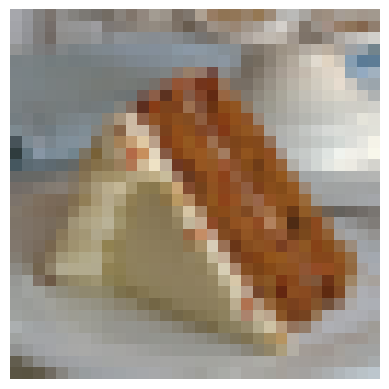

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint   = torch.load('model_checkpoints/checkpoint_epoch_2700.pth', map_location=device, weights_only=True)

epoch = checkpoint['epoch']

generator = generator.to(device)
discriminator = discriminator.to(device)

generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
optimizer_generator.load_state_dict(checkpoint['optimizer_gen_state_dict'])
optimizer_discriminator.load_state_dict(checkpoint['optimizer_disc_state_dict'])

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open("./crawled_cakes/017_af247c68.jpg").convert('RGB')
input_image = transform(image)

input_image_show = (input_image + 1) / 2

plt.imshow(input_image_show.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.show()

c:\Users\Mateusz\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1, 1, 1, 1, 3, 32, 32])) that is different to the input size (torch.Size([1, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


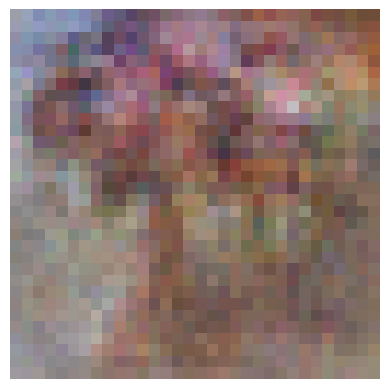

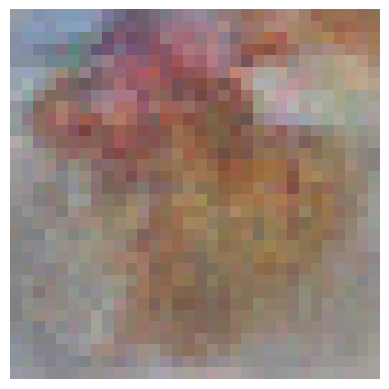

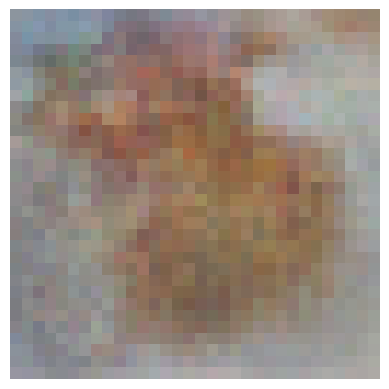

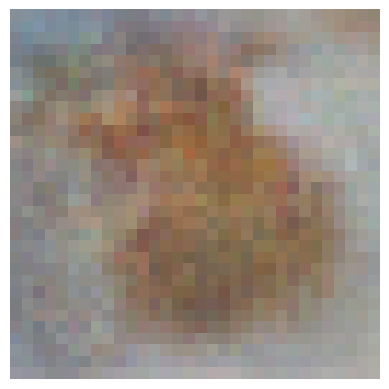

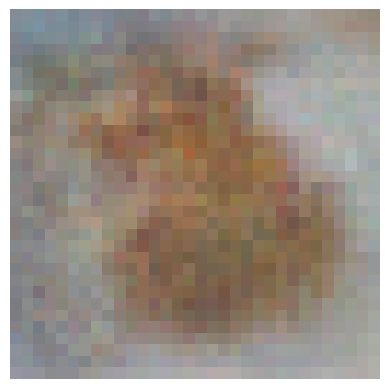

Ostateczny wektor wejściowy: tensor([[ 0.0385, -0.3217,  0.6080,  1.0875, -1.0272,  0.7380, -0.4853, -1.2284,
         -0.8246, -0.3730,  0.7945, -0.1772, -1.2257, -1.0971,  0.4144,  0.5976,
          1.4180,  0.2277,  0.8201,  0.8571, -0.3956, -2.1855, -1.4671, -0.2048,
         -0.8402,  0.5399,  1.5922, -0.8980, -0.8952, -0.3018, -1.3016, -0.4780,
          0.3449, -0.2177,  0.4038,  0.3134, -0.8784,  1.4408,  0.2289,  1.0823,
         -1.0490,  2.2837,  0.7352, -0.9814,  1.0860, -0.2585, -0.6888,  0.3799,
         -1.4300, -0.4616, -0.0284, -0.1629,  0.0280, -1.6680,  0.0344, -1.5609,
          0.0072, -1.0775, -0.5260,  0.4171, -0.9064, -1.2604, -0.0805,  1.2837]],
       device='cuda:0', requires_grad=True)


In [19]:
random_noise = torch.randn(1, 64, requires_grad=True, device=device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD([random_noise], lr=0.01, momentum=0.9)

input_image = input_image.unsqueeze(0).to(device)

for i in range(10000):
    optimizer.zero_grad()
    generated_image = generator(random_noise)
    loss = loss_fn(generated_image, input_image)

    loss.backward()
    optimizer.step()

    if i % 2000 == 0:
        input_image_show = (generated_image + 1) / 2
        plt.imshow(input_image_show.squeeze().permute(1, 2, 0).detach().cpu()) 
        plt.axis('off')
        plt.show()

final_vector = random_noise
final_vector_A = random_noise.detach().clone()
print("Ostateczny wektor wejściowy:", final_vector)

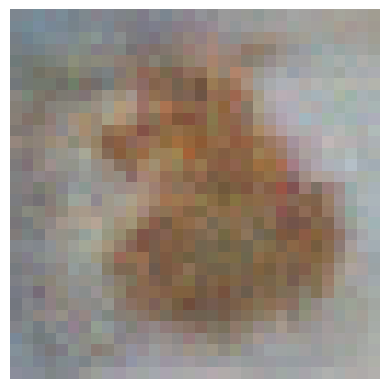

In [20]:
final_vector = final_vector.detach().clone()

final_vector[0][5], final_vector[0][13] = final_vector[0][13], final_vector[0][5]

with torch.no_grad():
    modified_image = generator(final_vector)

modified_image_show = (modified_image + 1) / 2
plt.imshow(modified_image_show.squeeze().permute(1, 2, 0).detach().cpu())
plt.axis('off')
plt.show()

Teraz zobaczymy jak moje sieci poradzą sobie z obrazem miniona:

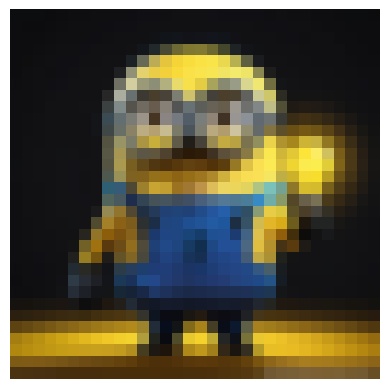

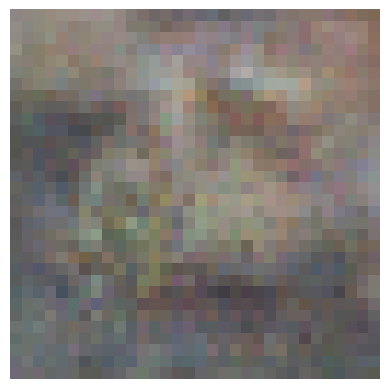

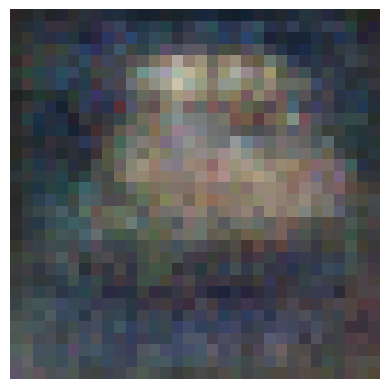

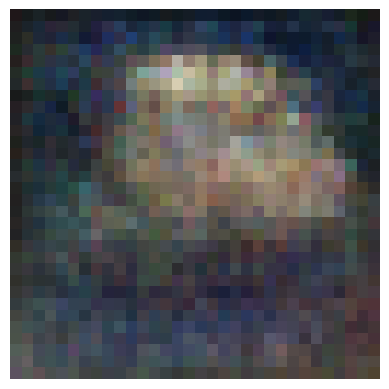

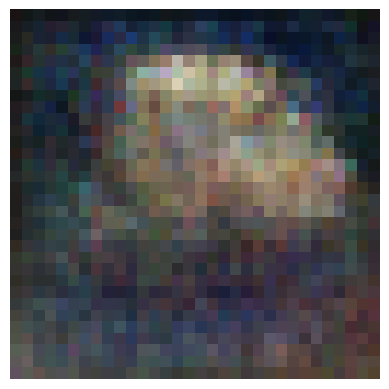

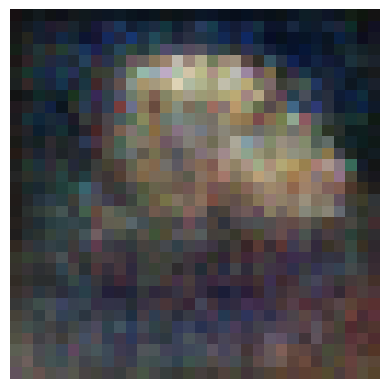

Ostateczny wektor wejściowy: tensor([[-2.8699, -2.3015,  0.0118, -0.4657,  0.8974,  0.7205, -0.3352,  0.8462,
          0.0950, -2.3276, -0.2270, -2.4582,  1.9243,  0.1252,  0.7881, -1.2852,
          1.2901, -0.1700, -0.5173,  0.1869,  1.0221,  0.9340, -0.9842, -1.1438,
          0.3834,  0.1172, -0.6493,  0.8808, -0.3446,  0.6225, -0.5379,  1.4074,
         -0.3709, -0.2273, -0.2229, -2.7586, -0.9767, -2.9846, -0.2267,  0.1837,
         -4.4907, -1.7159,  0.9925, -2.5781, -1.4061, -1.1050,  1.4101,  0.1587,
          2.8251, -1.3693,  0.6233,  0.3958, -1.9351, -0.5165,  0.3520,  1.1028,
          1.9558,  1.5778, -0.7288,  2.7030,  1.3719, -0.3218,  3.3391, -0.7651]],
       device='cuda:0', requires_grad=True)


In [21]:
image = Image.open("./minion.jpg").convert('RGB')
input_image = transform(image)

input_image_show = (input_image + 1) / 2

plt.imshow(input_image_show.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.show()

random_noise = torch.randn(1, 64, requires_grad=True, device=device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD([random_noise], lr=0.01, momentum=0.9)

input_image = input_image.unsqueeze(0).to(device)

for i in range(10000):
    optimizer.zero_grad()
    generated_image = generator(random_noise)
    loss = loss_fn(generated_image, input_image)

    loss.backward()
    optimizer.step()

    if i % 2000 == 0:
        input_image_show = (generated_image + 1) / 2
        plt.imshow(input_image_show.squeeze().permute(1, 2, 0).detach().cpu()) 
        plt.axis('off')
        plt.show()

final_vector = random_noise
print("Ostateczny wektor wejściowy:", final_vector)

Teraz biorę inne zdjęcie:

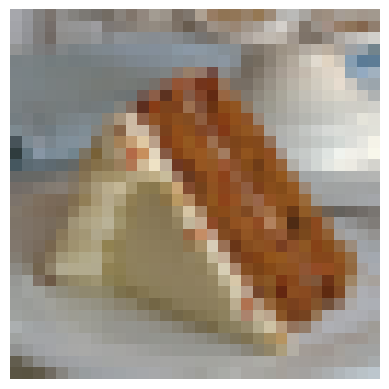

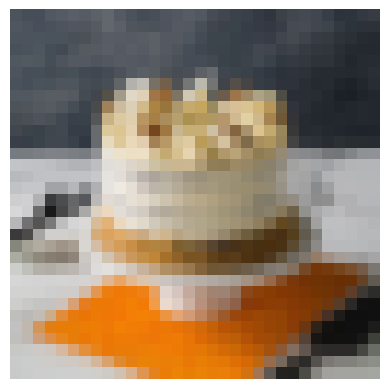

In [23]:
image_A = Image.open("./crawled_cakes/017_af247c68.jpg").convert('RGB')
input_image_A = transform(image_A)

input_image_show_A = (input_image_A + 1) / 2

plt.imshow(input_image_show_A.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.show()

image_B = Image.open("./crawled_cakes/046_351b1166.jpg").convert('RGB')
input_image_B = transform(image_B)

input_image_show_B = (input_image_B + 1) / 2

plt.imshow(input_image_show_B.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.show()


c:\Users\Mateusz\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1, 1, 3, 32, 32])) that is different to the input size (torch.Size([1, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


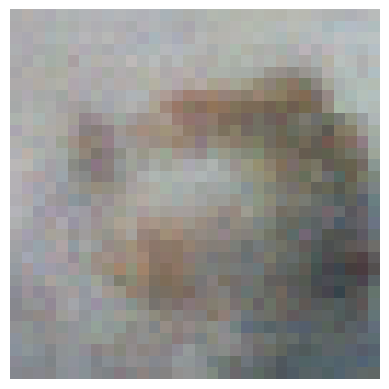

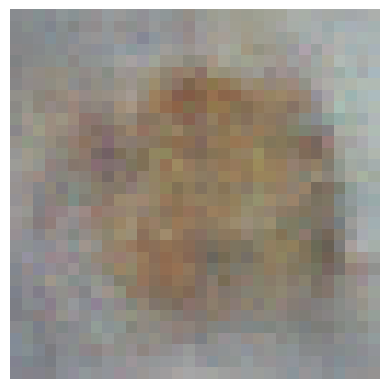

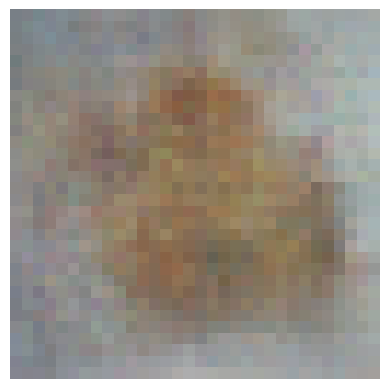

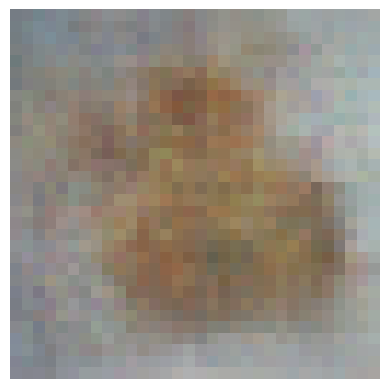

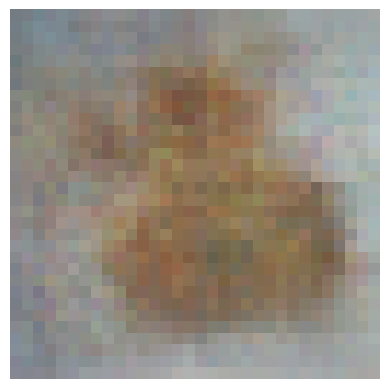

In [25]:
vector_B = torch.randn(1, 64, requires_grad=True, device=device)

optimizer = torch.optim.SGD([vector_B], lr=0.01, momentum=0.9)

input_image_B = input_image_B.unsqueeze(0).to(device)
input_image_A = input_image_A.unsqueeze(0).to(device)

for i in range(10000):
    optimizer.zero_grad()
    generated_image = generator(vector_B)
    loss = loss_fn(generated_image, input_image_A)

    loss.backward()
    optimizer.step()

    if i % 2000 == 0:
        input_image_show = (generated_image + 1) / 2
        plt.imshow(input_image_show.squeeze().permute(1, 2, 0).detach().cpu()) 
        plt.axis('off')
        plt.show()

final_vector_B = vector_B.detach().clone()

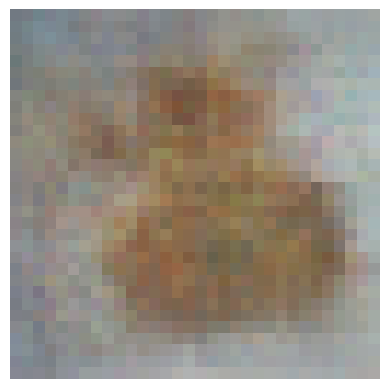

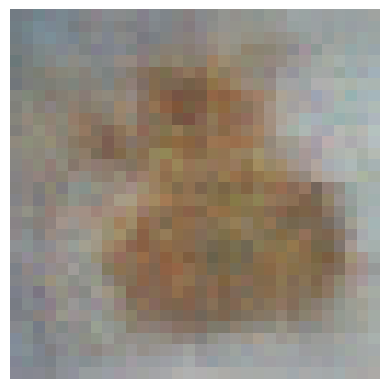

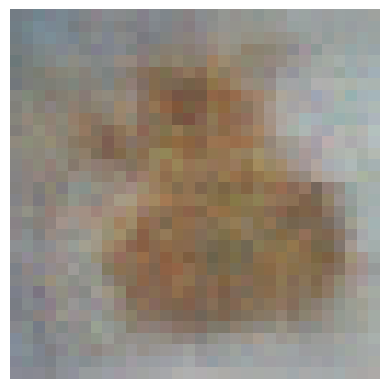

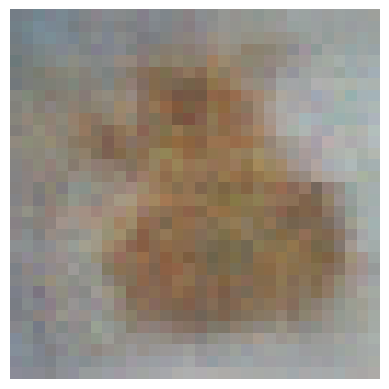

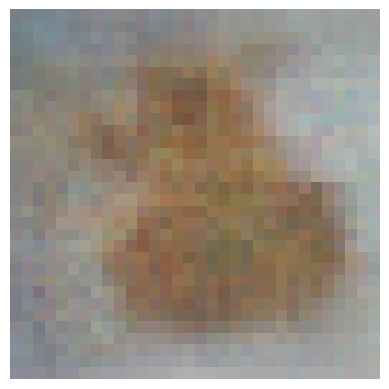

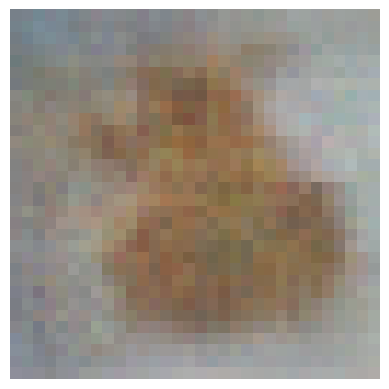

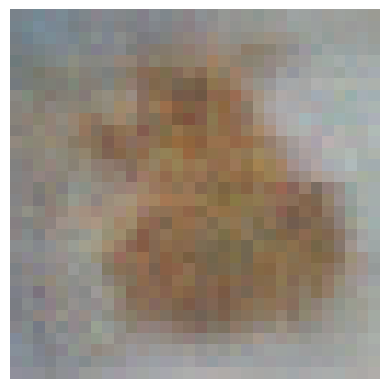

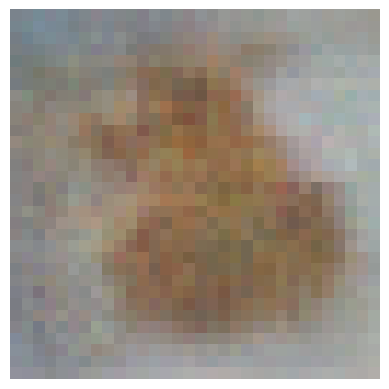

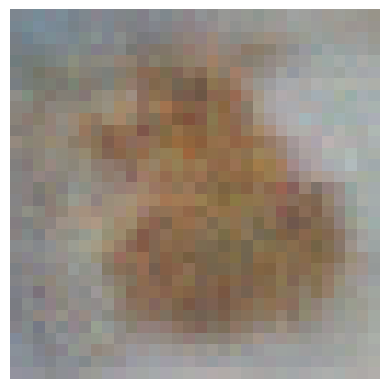

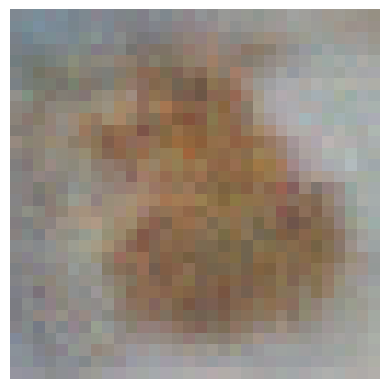

In [ ]:
vectors = []
num_steps = 10

for i in range(num_steps):
    interpolated_vector = final_vector_A * (1 - i / (num_steps - 1)) + final_vector_B * (i / (num_steps - 1))
    vectors.append(interpolated_vector)
    
    with torch.no_grad():
        generated_image = generator(interpolated_vector)

    input_image_show = (generated_image + 1) / 2
    plt.imshow(input_image_show.squeeze().permute(1, 2, 0).detach().cpu())
    plt.axis('off')
    plt.show()
